In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import os
import datetime
import numpy as np
import torch
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
# torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import wandb

from nca_model import NCAModel
from utils import nca_out_to_vids, tonp, save_model, load_latest_model
from mnist_data import MNISTGenerator
from clf_patterns import RadialCirclesProcessor, generate_start_pattern

In [21]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./train.ipynb"

In [72]:
device = "cuda"
num_classes = 10
chans = 16
bs = 32
S = 64
lr = 0.0008

In [4]:
nca = NCAModel(channel_n=chans, device=device)

In [5]:
inp = torch.rand(5, chans, S, S).to(device)
out = nca(inp, steps=50)
len(out), out[0].shape

(51, torch.Size([5, 16, 64, 64]))


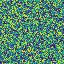
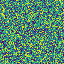
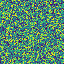
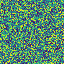
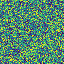

In [6]:
nca_out_to_vids(out)

In [7]:
gen = MNISTGenerator(bs=bs, num_classes=num_classes)

In [8]:
radial_processor = RadialCirclesProcessor(num_classes=num_classes, S=S)
start_pattern = generate_start_pattern(num_classes=num_classes, S=S)


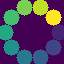

In [9]:
mpy.show_image(radial_processor.screen, cmap="viridis", width=150)

In [51]:
# mpy.show_image(start_pattern, cmap="viridis", width=150)

In [11]:
batch = next(gen)
inp, out = radial_processor.map_batch(batch, chans=chans)


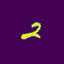
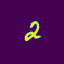
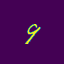
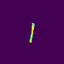
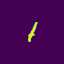
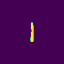
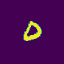
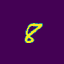

In [12]:
mpy.show_images(inp[:8,0], cmap="viridis", width=100, columns=8)


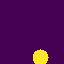
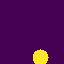
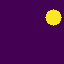
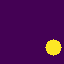
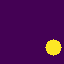
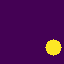
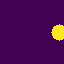
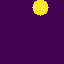

In [13]:
mpy.show_images(out[:8], cmap="viridis", width=100, columns=8)

In [14]:
nca = NCAModel(channel_n=chans, device=device)
train_gen = MNISTGenerator(bs=bs, num_classes=num_classes)
test_gen = MNISTGenerator(bs=16, num_classes=num_classes, is_train=False)

radial_processor = RadialCirclesProcessor(num_classes=num_classes, S=S)
star_pattern = generate_start_pattern(num_classes=num_classes, S=S)
star_pattern = star_pattern.to(inp.dtype).to(device)
star_pattern = star_pattern.unsqueeze(0).repeat(bs, 1, 1)

optim = torch.optim.Adam(nca.parameters(), lr=lr)
history = []

In [ ]:
run = wandb.init(
    project="nca-classifier",
    config={
        "learning_rate": LR,
    },
    save_code=True,
)
_ = run.log_code(
    "./",
    include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
)

Loss: 0.0185841657:  95%|#########4| 47400/50000 [9:28:52<30:09,  1.44it/s]

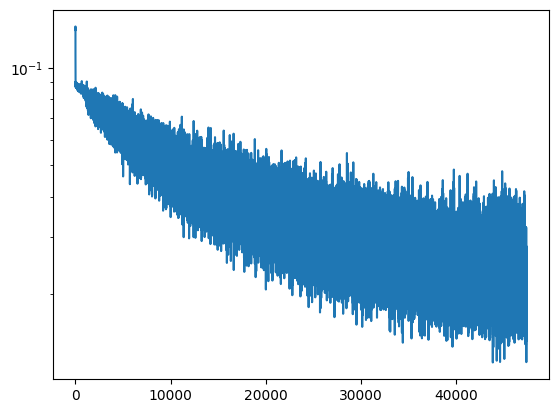


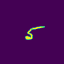
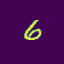
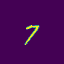
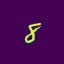
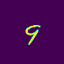
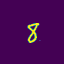
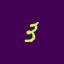
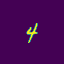
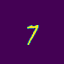
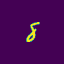
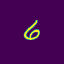
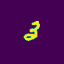
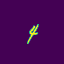
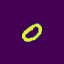
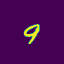
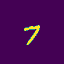

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
pbar = tqdm(range(50_000))

for i in pbar:
    batch = next(train_gen)
    inp, out_gt = radial_processor.map_batch(batch, chans=chans)
    out_gt = out_gt.to(device)

    steps = np.random.randint(50, 51)
    out_pred = nca(inp.to(device), steps=steps)
    out_pred = torch.stack(out_pred)

    mid_frame = out_pred[5, :, 0]
    last_frame = out_pred[-1:].mean(axis=0)[:, 0]
    last_frame2 = out_pred[-11:-10].mean(axis=0)[:, 0]

    loss = 0
#     loss += F.mse_loss(mid_frame, star_pattern)
    loss += F.mse_loss(last_frame, out_gt)
    loss += F.mse_loss(last_frame2, out_gt)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss:.10f}")
    run.log({"loss": loss.item()})
    history.append(loss.item())

    if i % 150 == 0:
        clear_output()
        display(pbar.container)
        
        plt.plot(history)
        plt.yscale("log")
        plt.show()
        
        batch = next(test_gen)
        inp, out_gt = radial_processor.map_batch(batch, chans=chans)
        out_pred = nca(inp.to(device), steps=50)
        nca_out_to_vids(out_pred, columns=8)

In [ ]:
run.finish()


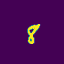
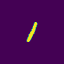
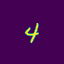
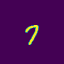
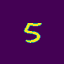
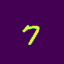
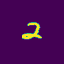
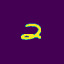
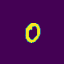
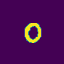
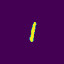
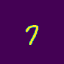
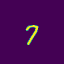
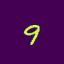
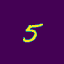
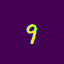

In [52]:
batch = next(test_gen)
inp, out_gt = radial_processor.map_batch(batch, chans=chans)
out_pred = nca(inp.to(device), steps=100)
nca_out_to_vids(out_pred, columns=8)

In [50]:
save_model(nca, ".checkpoints/nca-{now}.pkl")

In [74]:
# nca_loaded = load_latest_model(".checkpoints/")